In [1]:
using Pkg
Pkg.add(PackageSpec(url="https://github.com/AxelvL/AHPQ.jl", rev="master"))
using AHPQ

   Updating git-repo `https://github.com/AxelvL/AHPQ.jl`


   Updating registry at `C:\Users\Axel9\.julia\registries\General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


Fetching: [========================================>]  100.0 %

  Resolving package versions...
Updating `C:\Users\Axel9\.julia\environments\v1.5\Project.toml`
  [b1450aca] ~ AHPQ v0.1.0 `https://github.com/AxelvL/AHPQ.jl#master` ⇒ v0.1.0 `https://github.com/AxelvL/AHPQ.jl#master`
Updating `C:\Users\Axel9\.julia\environments\v1.5\Manifest.toml`
  [b1450aca] ~ AHPQ v0.1.0 `https://github.com/AxelvL/AHPQ.jl#master` ⇒ v0.1.0 `https://github.com/AxelvL/AHPQ.jl#master`
┌ Info: Precompiling AHPQ [b1450aca-318d-4cca-a6fa-ceaba11f2713]
└ @ Base loading.jl:1278


## Artificial Data Generation

In [2]:
using Plots
using Statistics: norm

In [3]:
n_dp = 1000
n_dim = 16
n_queries = 100
n_neighbors = 100

data = rand(n_dim, n_dp)
data = data ./ mapslices(norm, data, dims=1)
queries = rand(n_dim, n_queries)
innerproducts = data' * queries
groundtruth = mapslices(x -> partialsortperm(x, 1:n_neighbors, rev=true), innerproducts,dims=1);

## 16x1.000 Dataset and 8x8 codebook

In [4]:
n_codebooks = 8
n_centers   = 8
recalln = 20
stopcond= 2e-1;

### Finding optimal `T`

In [5]:
Ts = 0:0.1:1
scores = zeros(11)
for i in 1:length(Ts)
    traindata=deepcopy(data)
    ahpq = builder(traindata; T=Ts[i], n_codebooks=n_codebooks, 
                                    n_centers=n_centers,
                                    verbose=false,
                                    stopcond=stopcond,
                                    a=0,
                                    training_points=-1)
    yhat = AHPQ.MIPS(ahpq, queries, n_neighbors)
    scores[i] = recall1atN(yhat, groundtruth, recalln)
end

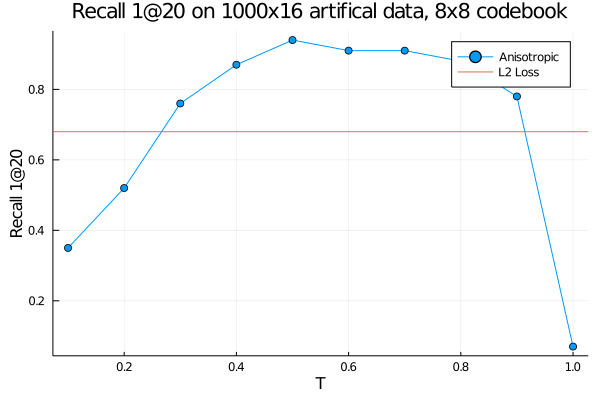

In [6]:
plot(Ts[2:end], scores[2:end], label="Anisotropic", marker=:dot)
hline!([scores[1]], label="L2 Loss")
plot!(title="Recall 1@$(recalln) on 1000x16 artifical data, $(n_codebooks)x$(n_centers) codebook", 
      xlabel="T",
      ylabel="Recall 1@$(recalln)")

### Comparison to L2 loss

#### Training Tuned Anisotropic PQ

In [8]:
traindata = deepcopy(data)
ahpq = builder(traindata, T=Ts[argmax(scores)], n_codebooks=n_codebooks, 
                                    n_centers=n_centers,
                                    verbose=false,
                                    stopcond=stopcond,
                                    a=0,
                                    training_points=-1);
yhat = AHPQ.MIPS(ahpq, queries, n_neighbors)
anisotropic_scores  = get1atNscores(yhat, n_neighbors, groundtruth);

#### Training L2 PQ

In [10]:
traindata = deepcopy(data)
ahpq = builder(traindata, T=0, n_codebooks=n_codebooks, 
                                    n_centers=n_centers,
                                    verbose=false,
                                    stopcond=stopcond,
                                    a=0,
                                    training_points=-1);
yhat = AHPQ.MIPS(ahpq, queries, n_neighbors)
L2_scores  = get1atNscores(yhat, n_neighbors, groundtruth);

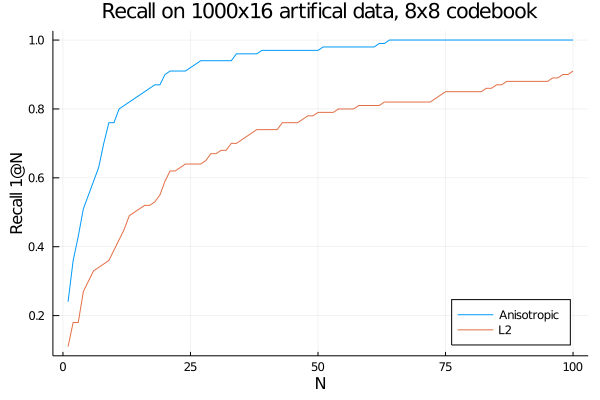

In [11]:
plot(1:100, anisotropic_scores, label="Anisotropic")
plot!(1:100, L2_scores, label="L2")
plot!(title="Recall on 1000x16 artifical data, $(n_codebooks)x$(n_centers) codebook", 
      xlabel="N",
      ylabel="Recall 1@N",
      legend=:bottomright)

## 100x1.000 Dataset: Varying `n_codebooks`

In [12]:
## Artificial Data Generation ##
n_dp = 1000
n_dim = 100
n_queries = 2000
n_neighbors = 100

data = rand(n_dim, n_dp)
data = data ./ mapslices(norm, data, dims=1)
queries = rand(n_dim, n_queries)
innerproducts = data' * queries
groundtruth = mapslices(x -> partialsortperm(x, 1:n_neighbors, rev=true), innerproducts,dims=1);

In [13]:
n_centers = 16
n_codebooks = [2, 5, 10, 25, 50, 100]
nrecall = 20
stopcond=1e-2;

### Tuning `T`

In [14]:
Ts = 0.001:0.1:1
scores = zeros(length(Ts))
for i in 1:length(Ts)
    traindata=deepcopy(data)
    ahpq = builder(traindata; T=Ts[i], n_codebooks=5, 
                                    n_centers=n_centers,
                                    verbose=false,
                                    stopcond=stopcond,
                                    a=0,
                                    training_points=-1,
                                    optimisation="nesterov")
    yhat = MIPS(ahpq, queries, n_neighbors)
    scores[i] = recall1atN(yhat, groundtruth, recalln)
end
print("Optimal T found at $(Ts[argmax(scores)])")

Optimal T found at 0.201

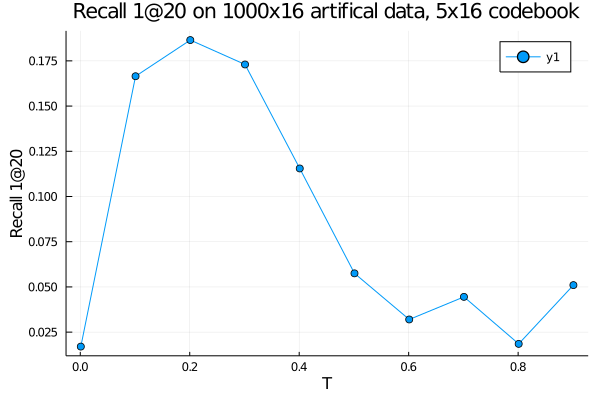

In [15]:
plot(Ts, scores[1:10], marker=:dot)
plot!(title="Recall 1@$(nrecall) on 1000x16 artifical data, 5x$(n_centers) codebook", 
      xlabel="T",
      ylabel="Recall 1@$(nrecall)")

### Performing tests

In [16]:
euclidean_errors = zeros(length(n_codebooks))
euclidean_scores = zeros(length(n_codebooks))
for i in 1:length(n_codebooks)
    traindata=deepcopy(data)
    ahpq = builder(traindata; T=0, n_codebooks=n_codebooks[i], 
                                    n_centers=n_centers,
                                    verbose=false,
                                    stopcond=stopcond,
                                    a=0,
                                    training_points=-1)
    euclidean_errors[i] = approx_error(ahpq.qd, data, groundtruth, queries)
    yhat = MIPS(ahpq, queries, n_neighbors)
    euclidean_scores[i] = recallN(yhat, groundtruth, nrecall)
end

In [17]:
anisotropic_errors = zeros(length(n_codebooks))
anisotropic_scores = zeros(length(n_codebooks))
for i in 1:length(n_codebooks)
    traindata=deepcopy(data)
    ahpq = builder(traindata; T=Ts[argmax(scores)], n_codebooks=n_codebooks[i], 
                                    n_centers=n_centers,
                                    verbose=false,
                                    stopcond=stopcond,
                                    a=0,
                                    training_points=-1)
    anisotropic_errors[i] = approx_error(ahpq.qd, data, groundtruth, queries)
    yhat = MIPS(ahpq, queries, n_neighbors)
    anisotropic_scores[i] = recallN(yhat, groundtruth, nrecall)
end

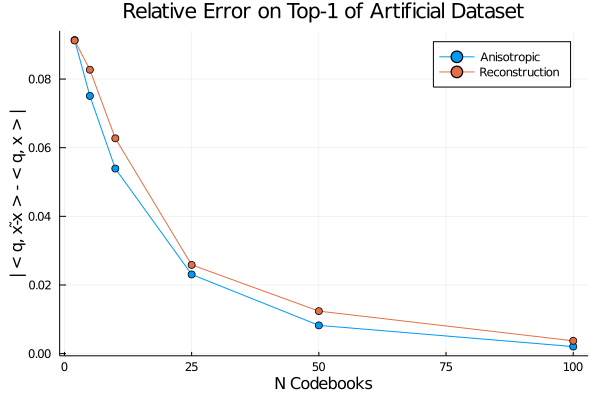

In [18]:
plot(n_codebooks, anisotropic_errors, marker=:dot, label="Anisotropic")
plot!(n_codebooks, euclidean_errors, marker=:dot, label="Reconstruction")
plot!(title="Relative Error on Top-1 of Artificial Dataset", 
      xlabel="N Codebooks",
      ylabel="| < q, x-̃x > - < q, x > |")

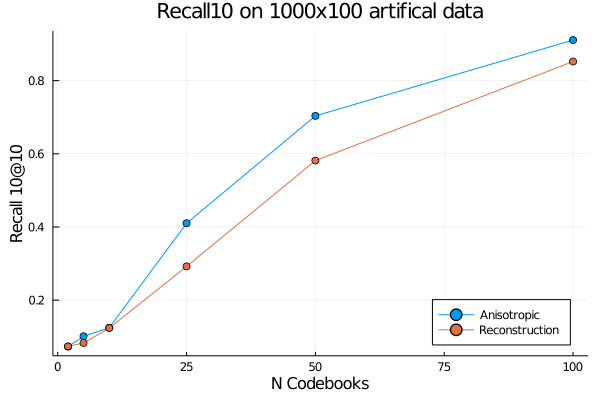

In [19]:
plot(n_codebooks, anisotropic_scores, marker=:dot, label="Anisotropic")
plot!(n_codebooks, euclidean_scores, marker=:dot, label="Reconstruction")
plot!(title="Recall10 on 1000x100 artifical data", 
      xlabel="N Codebooks",
      ylabel="Recall 10@10",
      legend=:bottomright)